In [1]:
import json

In [2]:
with open('train-v2.0.json') as f:
    train_dataset = json.load(f)

In [3]:
with open('dev-v2.0.json') as f:
    val_dataset = json.load(f)

In [4]:
from tqdm import tqdm
def extract_dataset(dataset):
    question_list = []
    answer_list = []
    answer_start_list = []
    paragraph_list = []
    answer_end_list = []
    for article in tqdm(dataset['data']):
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                try:
                    question = qa['question']
                    answer = [a['text'] for a in qa['answers']]
                    answer_start_list.append([a['answer_start'] for a in qa['answers']][0])
                    paragraph_list.append(paragraph['context'])
                    question_list.append(question)
                    answer_list.append(answer[0])
                    answer_end_list.append([a['answer_start'] for a in qa['answers']][0] + len(answer[0]))
                except IndexError:
                    m = 5
    return question_list, answer_list, answer_start_list, answer_end_list, paragraph_list

In [5]:
question_list, answer_list, answer_start_list, answer_end_list, paragraph_list = extract_dataset(train_dataset)
question_list_val, answer_list_val, answer_start_list_val, answer_end_list_val, paragraph_list_val = extract_dataset(val_dataset)

100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 2332.91it/s]


In [6]:
import pandas as pd
Squad_dic = {'Paragraph':paragraph_list, 'Question':question_list, 'Answer':answer_list, 'Answer_start': answer_start_list, 'Answer_end':answer_end_list }
Squad_df = pd.DataFrame(Squad_dic)

In [7]:
import pandas as pd
Squad_dic_dev = {'Paragraph':paragraph_list_val, 'Question':question_list_val, 'Answer':answer_list_val, 'Answer_start': answer_start_list_val, 'Answer_end':answer_end_list_val }
Squad_df_dev = pd.DataFrame(Squad_dic_dev)

In [8]:
Squad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86821 entries, 0 to 86820
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Paragraph     86821 non-null  object
 1   Question      86821 non-null  object
 2   Answer        86821 non-null  object
 3   Answer_start  86821 non-null  int64 
 4   Answer_end    86821 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.3+ MB


In [9]:
Squad_df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5928 entries, 0 to 5927
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Paragraph     5928 non-null   object
 1   Question      5928 non-null   object
 2   Answer        5928 non-null   object
 3   Answer_start  5928 non-null   int64 
 4   Answer_end    5928 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 231.7+ KB


In [10]:
Squad_df_dev.head()

,Paragraph,Question,Answer,Answer_start,Answer_end
0,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,159,165
1,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,94,117
2,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256,283
3,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,308,313
4,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,10th century,671,683


In [11]:
Squad_df.head()

,Paragraph,Question,Answer,Answer_start,Answer_end
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,286
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,226
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,530
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,180
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,286


In [12]:
Squad_df.to_csv('Squad_df_data.csv')

In [13]:
Squad_df_dev.to_csv('Squad_df_dev.csv')

In [14]:
import pandas as pd
Squad_df = pd.read_csv('Squad_df_data.csv')

In [15]:
Squad_df_dev = pd.read_csv('Squad_df_dev.csv')

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [17]:
from transformers import AutoTokenizer

In [18]:
# Initialize tokenizer.
tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2") 

<AxesSubplot:>

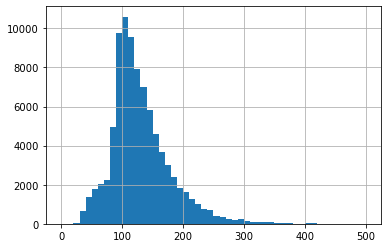

In [19]:
length_all = []
for i in range(len(Squad_df)):
    temp_length = len(Squad_df['Paragraph'][i].split()) + len(Squad_df['Question'][i].split())
    length_all.append(temp_length)
pd.Series(length_all).hist(bins = 50,range=[0,500])

In [20]:
Squad_df.head()

,Unnamed: 0,Paragraph,Question,Answer,Answer_start,Answer_end
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,286
1,1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,226
2,2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,530
3,3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,180
4,4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,286


In [21]:
Squad_df.iloc[1,5]

226

In [22]:
from torch.utils.data import Dataset, DataLoader
class Generate_moment_dataset(Dataset):
    def __init__(self, data_df, max_length):
        MAX_SEQ_LEN = max_length
        self.data = data_df
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        question = self.data.iloc[idx, 2]
        paragraph = self.data.iloc[idx, 1]
        question_start = self.data.iloc[idx, 4]
        question_end = self.data.iloc[idx, 5]
        question_start = torch.tensor(question_start).to(device)
        question_end = torch.tensor(question_end).to(device)
        SEP_TOKEN = tokenizer.sep_token_id
        PAD_TOKEN_index = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
        input_ids = tokenizer.encode(question, paragraph, max_length = MAX_SEQ_LEN)
        input_ids_final = input_ids + [PAD_TOKEN_index] * (MAX_SEQ_LEN - len(input_ids))
        sep_index = input_ids.index(SEP_TOKEN)
        num_seg_a = sep_index + 1
        num_seg_b = len(input_ids) - num_seg_a
        segment_ids = [0]*num_seg_a + [1]*num_seg_b + [1] * (MAX_SEQ_LEN - (num_seg_a + num_seg_b))      
        input_ids_final = torch.tensor(input_ids_final).to(device)
        segment_ids = torch.tensor(segment_ids).to(device)
        sample = {'input_ids': input_ids_final, 'token_type_ids': segment_ids, 'question_start': question_start, 'question_end':question_end}
        return sample

In [23]:
MAX_SEQ_LEN = 512
Batch_size = 4
train_moment_data = Generate_moment_dataset(Squad_df, MAX_SEQ_LEN)
valid_moment_data = Generate_moment_dataset(Squad_df_dev, MAX_SEQ_LEN)

In [24]:
train_moment_dataloader = DataLoader(train_moment_data, batch_size = Batch_size,shuffle=False)
valid_moment_dataloader = DataLoader(valid_moment_data, batch_size = Batch_size,shuffle=False)

In [25]:
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2").to(device)

In [26]:
# Training Function
def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5):
    valid_period = len(train_iter)
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    global_step = 0
    global_steps_list = []
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for data in train_iter:
            source = data['input_ids']
            type_to = data['token_type_ids']
            question_start = data['question_start']
            question_end = data['question_end']
            loss,answer_start_index,answer_end_index  = model(input_ids = source, token_type_ids = type_to, start_positions=question_start,end_positions=question_end)
            print('batch_no [{}/{}]:'.format(count, int(len(train_iter))),'training_loss:',loss)
            count+=1
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for data in valid_iter:
                        source = data['input_ids']
                        type_to = data['token_type_ids']
                        question_start = data['question_start']
                        question_end = data['question_end']
                        loss,answer_start_index,answer_end_index  = model(input_ids = source, token_type_ids = type_to, start_positions=question_start,end_positions=question_end )
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    print('Training done!')

In [27]:
print("======================= Start training =================================")
steps_per_epoch = len(train_moment_dataloader)
NUM_EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)
predict_all = train(model=model, 
      train_iter=train_moment_dataloader,
      valid_iter=valid_moment_dataloader,
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

======================= Start training =================================
batch_no [0/21706]: training_loss: tensor(10.7563, device='cuda:0', grad_fn=<DivBackward0>)
batch_no [1/21706]: training_loss: tensor(11.1969, device='cuda:0', grad_fn=<DivBackward0>)
batch_no [2/21706]: training_loss: tensor(11.1713, device='cuda:0', grad_fn=<DivBackward0>)
batch_no [3/21706]: training_loss: tensor(9.2357, device='cuda:0', grad_fn=<DivBackward0>)
batch_no [4/21706]: training_loss: tensor(13.3883, device='cuda:0', grad_fn=<DivBackward0>)
batch_no [5/21706]: training_loss: tensor(10.7378, device='cuda:0', grad_fn=<DivBackward0>)
batch_no [6/21706]: training_loss: tensor(12.7806, device='cuda:0', grad_fn=<DivBackward0>)
batch_no [7/21706]: training_loss: tensor(0., device='cuda:0', grad_fn=<DivBackward0>)
batch_no [8/21706]: training_loss: tensor(7.5776, device='cuda:0', grad_fn=<DivBackward0>)
batch_no [9/21706]: training_loss: tensor(10.2437, device='cuda:0', grad_fn=<DivBackward0>)
batch_no [10/2

KeyboardInterrupt: 

In [50]:
from tqdm import tqdm
def evaluate(model, validation_dataloader):
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    all_results = []
    model.eval()
    count = 0
    true_word = []
    pred_word = []
    with torch.no_grad():
        for data in tqdm(validation_dataloader):
            source = data['input_ids']
            type_to = data['token_type_ids']
            question_start = data['question_start']
            question_end = data['question_end']
            loss,answer_start_index,answer_end_index  = model(input_ids = source, token_type_ids = type_to, start_positions=question_start,end_positions=question_end )
            for i in range(Batch_size):
                answer_start = torch.argmax(answer_start_index[i])
                answer_end = torch.argmax(answer_end_index[i])
                input_ids = source[i].tolist()
                tokens = tokenizer.convert_ids_to_tokens(input_ids)
                start_index = Squad_df_dev['Answer_start'][count]
                true_word.append(Squad_df_dev['Answer'][count])
                pred_word.append(' '.join(tokens[answer_start:answer_end+1]))
                count+=1
    return true_word, pred_word
                

In [69]:
true_word, pred_word = evaluate(model, valid_moment_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████| 1482/1482 [02:50<00:00,  8.67it/s]


In [71]:
true_word_temp, pred_word_temp = true_word, pred_word 

In [79]:
count = 0
for i in range(len(pred_word)):
    true_word_temp[i] = true_word_temp[i].replace(" ",'')
    pred_word_temp[i] = pred_word_temp[i].replace(" ",'')
    pred_word_temp[i] = pred_word_temp[i].replace('#','')
    if pred_word_temp[i] in true_word_temp[i]:
        count+=1
    if len(true_word_temp[i]) < len(pred_word_temp[i]) and true_word_temp[i] in pred_word_temp[i]:
        count+=1

In [81]:
for i in range(len(pred_word)):
    print(pred_word[i],'----',true_word[i])

France ---- France
10thand11thcenturies ---- 10thand11thcenturies
 ---- Denmark,IcelandandNorway
Rollo ---- Rollo
10thcentury ---- 10thcentury
WilliamtheConqueror ---- WilliamtheConqueror
RichardI ---- RichardI
Christianpiety ---- Catholic
[CLS] ---- Viking
[CLS] ---- 9thcentury
911 ---- 911
 ---- KingCharlesIII
Seine ---- Seine
[CLS] ---- Rollo
 ---- Catholicism
north ---- north
fightinghorsemen ---- fightinghorsemen
thePechenegs,theBulgars,andespeciallytheSeljukTurks ---- SeljukTurks
[CLS] ---- 1050s
the1060s ---- 1060s
[CLS] ---- AlexiusKomnenos
Afranji ---- Afranji
Oursel ---- Oursel
 ---- Turkishforces
TheRaouliiweredescendedfromanItalo-NormannamedRaoul ---- Normanmercenary
[CLS] ---- RobertGuiscard
 ---- 1082
30,000 ---- 30,000
Deabolis ---- Deabolis
Bohemond ---- Bohemond
Deabolis ---- Deabolis
1185 ---- 1185
 ---- Dyrrachium
Adriatic ---- theAdriatic
KingEthelredIIofEngland ---- KingEthelredII
[CLS] ---- DukeRichardII
Normandy ---- Normandy
[CLS] ---- SweynForkbeard
Harthacnut 

1622 ---- 1622
[CLS] ---- EdictofAlès
1629 ---- 1629
CapeofGoodHopefromasearlyas1671withthearrivalofFrançoisVillion(Viljoen).ThefirstHuguenottoarriveattheCapeofGoodHopewashoweverMariadelaQueillerie,wifeofcommanderJanvanRiebeeck(anddaughterofaWalloonchurchminister),whoarrivedon6April1652toestablishasettlementatwhatistodayCapeTown ---- attheCapeofGoodHope
[CLS] ---- CapeTown
MariadelaQueillerie ---- MariadelaQueillerie
EastIndiaCompany ---- DutchEastIndiaCompany
1700 ---- 1700
1624 ---- 1624
JessédeForest ---- JessédeForest
L'EgliseduSaint-Esprit ---- L'ÉglisefrançaiseàlaNouvelle-Amsterdam
L'EgliseduSaint-Esprit ---- L'EgliseduSaint-Esprit
Brooklyn ---- Brooklyn
Charleston ---- Charleston,SouthCarolina
Charleston ---- theCharlestonOrangedistrict
1697 ---- 1697
BritishLandgraveEdmundBellinger ---- theBritishLandgraveEdmundBellinger
Pons ---- Pons
[CLS]WhowasLouisXIV'smainrival?[SEP]StadtholderWilliamIIIofOrange,wholaterbecameKingofEngland,emergedasthestrongestopponentofkingLouisXIVafterth

 ---- congressesandpresidents
U.S. ---- U.S
British ---- BritishPrimeMinisterEdwardHeath
10years ---- 10years
theArabsandmuchoftherestoftheThirdWorld ---- ArabsandmuchoftherestoftheThirdWorld
Japan ---- Japan
71% ---- 71%
declaredJapana"nonfriendly"countrytoencourageittochangeitsnoninvolvementpolicy ---- 5%productioncut
November22 ---- November22
December25 ---- December25
[CLS] ---- USSR'sinvasion
SaudiArabiaandIran ---- SaudiArabiaandIran
[CLS] ---- SaudiArabia
[CLS] ---- January1979
[CLS] ---- November1979
[CLS] ---- largecars
 ---- Japaneseimports
fourcylinderenginesthatweremorefuelefficientthanthetypicalAmericanV8andsixcylinderengines ---- V8andsixcylinderengines
Japanese ---- Japan
[CLS] ---- Adecadeafterthe1973
ToyotaCoronaMarkII,theToyotaCressida ---- ToyotaCoronaMarkII
passengerspaceandamenitiessuchasairconditioning,powersteering,AM-FMradios,andevenpowerwindowsandcentrallocking ---- powersteering
Acura,LexusandInfiniti ---- Lexus
ToyotaHiluxandtheDatsunTruck ---- ToyotaHilux
D

[CLS] ---- 2.2inches
3.55inches ---- 3.55inches
494,665 ---- 494,665
[CLS] ---- 49.6%
8,525 ---- 8,525
30.0% ---- 30.0%
4,404.5 ---- 4,404.5people
68,511 ---- 68,511
19.3% ---- 19.3%
1,388 ---- 1,388
3.62 ---- 3.62
3.62 ---- 3.07
427,652 ---- 427,652
149,025 ---- 149,025
8.4% ---- 8.4%
athird ---- athird
4,097.9peoplepersquaremile ---- 4,097.9peoplepersquaremile
[CLS] ---- ToavoidinterferencewithexistingVHFtelevisionstations
KMJ-TV ---- KMJ-TV
June1,1953 ---- June1,1953
NBCaffiliateKSEE ---- NBCaffiliateKSEE
KGPE ---- KGPE
freeway ---- StateRoute99
SierraFreeway ---- theSierraFreeway
EisenhowerFreeway ---- StateRoute41
west ---- west
[CLS] ---- Fresno
1950s ---- 1950s
Interstate9 ---- 99
rapidlyraisingpopulationandtrafficincitiesalongSR99,aswellasthedesirabilityofFederalfunding ---- rapidlyraisingpopulationandtrafficincitiesalongSR99
AmtrakSanJoaquins ---- AmtrakSanJoaquins
DowntownFresno ---- DowntownFresno
BurlingtonNorthernSantaFeRailwayandUnionPacificRailroad ---- BurlingtonNorther

Materialsreadilyavailableinthearea ---- Materialsreadilyavailableinthearea
[CLS] ---- alotofwaste
 ---- Costofconstruction
3Dprintingtechnology ---- 3Dprintingtechnology
around20hours ---- around20hours
2014 ---- Workingversionsof3D-printingbuildingtechnologyarealreadyprinting
2metres(6ft7in) ---- 2metres(6ft7in)
designsintoreality ---- designsintoreality
planthephysicalproceedings ---- planthephysicalproceedings,andtointegratethoseproceedingswiththeotherparts
thepropertyowner ---- thepropertyowner
aquantitysurveyor ---- aquantitysurveyor
themostcostefficientbidder ---- themostcostefficientbidder
previouslyseparatedspecialties ---- previouslyseparatedspecialties
separatecompanies ---- entirelyseparatecompanies
one-stopshopping ---- "one-stopshopping"
designbuild" ---- "designbuild"contract
[CLS]Whatprojectstructuresassisttheownerinintegration?[SEP]Severalprojectstructurescanassisttheownerinthisintegration,includingdesign-build,partneringandconstructionmanagement ---- design-build,partn

MiltonFriedmanInstitute ---- MiltonFriedmanInstitute
$200million ---- around$200million
ChicagoTheologicalSeminary ---- theChicagoTheologicalSeminary
DavidG.Booth ---- DavidG.Booth
[CLS] ---- theMainQuadrangles
six ---- six
Cobb,Shepley,RutanandCoolidge,Holabird&Roche ---- Cobb,Shepley,RutanandCoolidge,Holabird&Roche,
MagdalenTower ---- Oxford'sMagdalenTower
ChristChurchHall ---- ChristChurchHall
[CLS] ---- the1940s
EeroSaarinen ---- EeroSaarinen
SchoolofSocialServiceAdministration ---- SchoolofSocialServiceAdministration
 ---- HarrisSchoolofPublicPolicyStudies
2003 ---- 2003
Singapore,London,andthedowntownStreetervilleneighborhoodofChicago ---- Singapore,London,andthedowntownStreetervilleneighborhoodofChicago
Seine ---- Seine
[CLS] ---- 2010
[CLS] ---- RenminUniversity
2015 ---- 2015
aboardoftrustees ---- aboardoftrustees
50 ---- 50
fourteen ---- fourteen
AndrewAlper ---- AndrewAlper
DanielDiermeier ---- RobertZimmer
TheHigherLearningCommission ---- TheHigherLearningCommission
four --

[CLS]OfwhatformdoFermatnumberstake?[SEP]AftertheGreeks,littlehappenedwiththestudyofprimenumbersuntilthe17thcentury.In1640PierredeFermatstated(withoutproof)Fermat'slittletheorem(laterprovedbyLeibnizandEuler).Fermatalsoconjecturedthatallnumbersoftheform22n+1areprime(theyarecalledFermatnumbers)andheverifiedthisupton=4(or216+1).However,theverynextFermatnumber232+1iscomposite ---- 22n+1
upton=4 ---- upton=4(or216+1)
[CLS]OfwhatformdoMersenneprimestake?[SEP]AftertheGreeks,littlehappenedwiththestudyofprimenumbersuntilthe17thcentury.In1640PierredeFermatstated(withoutproof)Fermat'slittletheorem(laterprovedbyLeibnizandEuler).Fermatalsoconjecturedthatallnumbersoftheform22n+1areprime(theyarecalledFermatnumbers)andheverifiedthisupton=4(or216+1).However,theverynextFermatnumber232+1iscomposite(oneofitsprimefactorsis641),asEulerdiscoveredlater,andinfactnofurtherFermatnumbersareknowntobeprime.TheFrenchmonkMarinMersennelookedatprimesoftheform2p−1 ---- 2p−1
trialdivision ---- trialdivision
ifacompletelis

[CLS] ---- destructionofIsrael
Palestine ---- Palestine
alcohol ---- alcohol
[CLS] ---- Hamas
542 ---- 542
themajorityoftheseats ---- majorityoftheseats,
2007 ---- 2007
drivingIsraeloutoftheGazaStrip ---- drivingIsraeloutoftheGazaStrip
Islamist ---- Islamist
Hassanal-Turabi ---- Hassanal-Turabi
NationalIslamicFront ---- NationalIslamicFront
moneyfromforeignIslamistbankingsystems ---- moneyfromforeignIslamistbankingsystems
universityandmilitaryacademy ---- universityandmilitaryacademy
1985 ---- 1985
withthehelpofthemilitary ---- withthehelpofthemilitary
[CLS] ---- sharialaw
OsamabinLaden ---- OsamabinLaden
AmericanattackonIraqinthe1991GulfWar ---- AmericanattackonIraq
FrontIslamiquedeSalut ---- FrontIslamiquedeSalut
Algeria ---- Algeria
1989 ---- 1989
alleviatethehighrateofunemploymentamongyoungAlgerianmen ---- stayinghome
militarycoupd'état ---- amilitarycoupd'état
justiceandprosperity ---- justiceandprosperity
viciousanddestructive ---- viciousanddestructive
[CLS] ---- oneofthepoorest

[CLS] ---- Newton'sThird
thirdlaw ---- Newton'sThird
unidirectionalforce ---- unidirectional
 ---- magnitude
thecenterofmass ---- centerofmass
closed ---- closed
themassofthesystem ---- massofthesystem
intuitiveunderstanding ---- intuitiveunderstanding
[CLS] ---- standardmeasurementscale
Newtonianmechanics ---- Newtonianmechanics
experimentation ---- experimentation
vectorquantities ---- vectorquantities
[CLS] ---- denotedscalarquantities
vectors ---- Associatingforceswithvectors
ambiguous ---- ambiguous
 ---- Associatingforceswithvectors
staticequilibrium ---- staticequilibrium
magnitudeanddirection ---- magnitudeanddirection
netforce ---- netforce
theirrespectivelinesofapplication ---- respectivelinesofapplication
pointparticle ---- parallelogram
independentcomponents ---- independentcomponents
twoforces ---- two
theoriginalforce ---- theoriginalforce
[CLS] ---- orthogonal
[CLS] ---- three-dimensional
staticfriction ---- staticfriction
staticfriction ---- staticfriction
appliedforcer

In [82]:
print("Accuracy:",count/len(pred_word))

Accuracy: 0.7736167341430499


In [86]:
PATH = "bert_NLP_QA_model.pt"
torch.save(model.state_dict(), PATH)

## Wiki test

In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [2]:
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2").to(device)

In [60]:
model

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [3]:
PATH = "bert_NLP_QA_model.pt"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2") 

In [82]:
import wikipedia as wiki
import pprint as pp
from collections import OrderedDict
def btn_eventhandler(obj):
    results = wiki.search(question)
    page = wiki.page(results[0])
    
    text = page.content

    inputs = tokenizer.encode_plus(question, text, return_tensors='pt')
    qmask = inputs['token_type_ids'].lt(1)
    qt = torch.masked_select(inputs['input_ids'], qmask)
    chunk_size = model.config.max_position_embeddings - qt.size()[0] - 1 # the "-1" accounts for

    chunked_input = OrderedDict()
    for k,v in inputs.items():
        q = torch.masked_select(v, qmask)
        c = torch.masked_select(v, ~qmask)
        chunks = torch.split(c, chunk_size)

        for i, chunk in enumerate(chunks):
            if i not in chunked_input:
                chunked_input[i] = {}

            thing = torch.cat((q, chunk))
            if i != len(chunks)-1:
                if k == 'input_ids':
                    thing = torch.cat((thing, torch.tensor([102])))
                else:
                    thing = torch.cat((thing, torch.tensor([1])))

            chunked_input[i][k] = torch.unsqueeze(thing, dim=0).to(device)
    def convert_ids_to_string(tokenizer, input_ids):
        return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids))
    answer = []
    for _, chunk in chunked_input.items():
        answer_start_scores, answer_end_scores = model(**chunk)
        answer_start = torch.argmax(answer_start_scores)
        answer_end = torch.argmax(answer_end_scores) + 1

        ans = convert_ids_to_string(tokenizer, chunk['input_ids'][0][answer_start:answer_end])

        # if the ans == [CLS] then the model did not find a real answer in this chunk
        if ans != '[CLS]':
            if len(ans)!=0:

                answer.append(ans)
    #         answer += ans + " / "
    count = 1
    for i in answer:
        print('Possible answer No.{} : {}'.format(count,i))
        count +=1


In [70]:
# when did Justin Biebers song "baby" released?
# When is BERT model published

### Input your question

In [74]:
import ipywidgets
txtsl = ipywidgets.Text(
 placeholder='Enter you question',
 description='question:'
 )

display(txtsl)

Text(value='', description='question:', placeholder='Enter you question')

In [85]:
question = txtsl.value

In [86]:
btn = ipywidgets.Button(description='Check Answer')
display(btn)
btn.on_click(btn_eventhandler)

Button(description='Check Answer', style=ButtonStyle())

Possible answer No.1 : Gangkhar Puensum
